In [594]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import math
from plotnine import *

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture

import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_score, r2_score, mean_squared_error, mean_absolute_error
from sklearn.neighbors import NearestNeighbors

from sklearn.linear_model import RidgeCV, LassoCV

# For logistic regression
from sklearn.linear_model import LogisticRegression, Ridge, Lasso # Logistic Regression Model
from sklearn.tree import DecisionTreeClassifier # Decision Tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

from sklearn import metrics 
from sklearn.preprocessing import StandardScaler #Z-score variables

from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.model_selection import KFold # k-fold cv
from sklearn.model_selection import cross_val_score # cross validation metrics
from sklearn.model_selection import cross_val_predict # cross validation metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics._plot.roc_curve import plot_roc_curve

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, plot_confusion_matrix, f1_score, recall_score, precision_score

In [595]:
fields = ['GenderSelect', 'Country', 'Age', 'EmploymentStatus', 'CodeWriter', 'StudentStatus', 'CurrentJobTitleSelect', 'LanguageRecommendationSelect', 'LearningDataScienceTime', 'TimeSpentStudying', 'FormalEducation', 'CompensationAmount', 'JobHuntTime', 'EmployerSearchMethod', 'WorkToolsSelect']
df = pd.read_csv("Datasets/multipleChoiceResponses.csv", usecols = fields , encoding = 'latin-1')

df.head()

,GenderSelect,Country,Age,EmploymentStatus,StudentStatus,CodeWriter,CurrentJobTitleSelect,LanguageRecommendationSelect,LearningDataScienceTime,TimeSpentStudying,FormalEducation,EmployerSearchMethod,WorkToolsSelect,CompensationAmount,JobHuntTime
0,"Non-binary, genderqueer, or gender non-conforming",NaN,NaN,Employed full-time,NaN,Yes,DBA/Database Engineer,F#,NaN,NaN,Bachelor's degree,I visited the company's Web site and found a j...,"Amazon Web services,Oracle Data Mining/ Oracle...",NaN,NaN
1,Female,United States,30.0,"Not employed, but looking for work",NaN,NaN,NaN,Python,1-2 years,2 - 10 hours,Master's degree,NaN,NaN,NaN,NaN
2,Male,Canada,28.0,"Not employed, but looking for work",NaN,NaN,NaN,R,1-2 years,2 - 10 hours,Master's degree,NaN,NaN,NaN,1-2
3,Male,United States,56.0,"Independent contractor, freelancer, or self-em...",NaN,Yes,Operations Research Practitioner,Python,NaN,NaN,Master's degree,NaN,"Amazon Machine Learning,Amazon Web services,Cl...","250,000",NaN
4,Male,Taiwan,38.0,Employed full-time,NaN,Yes,Computer Scientist,Python,NaN,NaN,Doctoral degree,A tech-specific job board,"C/C++,Jupyter notebooks,MATLAB/Octave,Python,R...",NaN,NaN


In [596]:
df.shape

(16716, 15)

In [597]:
# Data Cleanup

# Simplify data in GenderSelect
df = df[df['GenderSelect'].isin(['Male','Female'])]

# Only United States Participants
df = df[df['Country'] == 'United States']

# Drop those who didnt input their age
df = df.dropna(subset=['Age'])

# Drop 'prefer not to answer' for FormalEducation
df = df[~df['FormalEducation'].isin(['I prefer not to answer'])]

# Drop 'Some other way' for EmployerSearchMethod
df = df[~df['EmployerSearchMethod'].isin(['Some other way'])]

# Simplify EmploymentStatus, if employed: 1, else: 0
df['isEmployed'] = df['EmploymentStatus'].apply(lambda x: 1 if any(s in x for s in ['full-time', 'freelancer']) else 0)

# Convert StudentStatus null values to 0
df['StudentStatus'] = df['StudentStatus'].astype(str).apply(lambda x: 1 if 'Yes' in x else 0)

# Only show those who have a job in analyzing data, software or programming
jobTypes = ['Data', 'Software', 'Computer', 'Database', 'Business Analyst', 'Machine Learning', 'Programmer']
df['CodeWriter'] = df['CodeWriter'].apply(lambda x: 1 if x == 'Yes' else 0)
df = df[df['CurrentJobTitleSelect'].isin(jobTypes) | df['CodeWriter'] == 1]

# Drop those who didnt put their annual salary
df = df.dropna(subset=['CompensationAmount'])

# Convert the salary from a string to an integer value
df['CompensationAmount'] = df['CompensationAmount'].apply(lambda x: int(float(x.replace(',', ''))))

In [598]:
# Simplifying labels
df['FormalEducation'] = df['FormalEducation'].replace('I did not complete any formal education past high school', 'high_school')
df['FormalEducation'] = df['FormalEducation'].replace('Some college/university study without earning a bachelor\'s degree', 'some_college')
df['FormalEducation'] = df['FormalEducation'].replace('Professional degree', 'professional')
df['FormalEducation'] = df['FormalEducation'].replace('Bachelor\'s degree', 'bachelors')
df['FormalEducation'] = df['FormalEducation'].replace('Master\'s degree', 'masters')
df['FormalEducation'] = df['FormalEducation'].replace('Doctoral degree', 'PhD')

df['EmployerSearchMethod'] = df['EmployerSearchMethod'].replace('A career fair or on-campus recruiting event', 'campus_recruitment')
df['EmployerSearchMethod'] = df['EmployerSearchMethod'].replace('A friend, family member, or former colleague told me', 'referral')
df['EmployerSearchMethod'] = df['EmployerSearchMethod'].replace(['A general-purpose job board', 'A tech-specific job board', 'I visited the company\'s Web site and found a job listing there'], 'job_board')
df['EmployerSearchMethod'] = df['EmployerSearchMethod'].replace(['I was contacted directly by someone at the company (e.g. internal recruiter)', 'An external recruiter or headhunter'], 'recruiter')

In [599]:
# Create dummies for GenderSelect, FormalEducation and EmployerSearchMethod
dummies = pd.get_dummies(df['GenderSelect'])
df = pd.concat([df, dummies], axis = 1)
df = df.drop('GenderSelect', 1)

dummies = pd.get_dummies(df['FormalEducation'])
df = pd.concat([df, dummies], axis = 1)
df = df.drop('FormalEducation', 1)

dummies = pd.get_dummies(df['EmployerSearchMethod'])
df = pd.concat([df, dummies], axis = 1)
df = df.drop('EmployerSearchMethod', 1)

In [600]:
df.head()

,Country,Age,EmploymentStatus,StudentStatus,CodeWriter,CurrentJobTitleSelect,LanguageRecommendationSelect,LearningDataScienceTime,TimeSpentStudying,WorkToolsSelect,...,PhD,bachelors,high_school,masters,professional,some_college,campus_recruitment,job_board,recruiter,referral
3,United States,56.0,"Independent contractor, freelancer, or self-em...",0,1,Operations Research Practitioner,Python,NaN,NaN,"Amazon Machine Learning,Amazon Web services,Cl...",...,0,0,0,1,0,0,0,0,0,0
15,United States,58.0,"Independent contractor, freelancer, or self-em...",0,1,DBA/Database Engineer,R,NaN,NaN,"C/C++,IBM Cognos,MATLAB/Octave,Microsoft Excel...",...,0,0,0,1,0,0,0,0,0,0
22,United States,33.0,Employed full-time,0,1,Scientist/Researcher,Matlab,NaN,NaN,"MATLAB/Octave,Python",...,1,0,0,0,0,0,0,0,0,1
34,United States,35.0,Employed full-time,0,1,Engineer,Python,NaN,NaN,"MATLAB/Octave,Python,R,SAS JMP,SQL,TIBCO Spotfire",...,1,0,0,0,0,0,0,0,0,1
75,United States,40.0,Employed full-time,0,1,Scientist/Researcher,Python,NaN,NaN,"Amazon Machine Learning,C/C++,NoSQL,R",...,1,0,0,0,0,0,0,0,0,1


In [601]:
predictors = ['Male','Female','Age', 'CompensationAmount',
    'PhD', 'bachelors', 'high_school', 'masters', 'professional',
    'some_college', 'campus_recruitment', 'job_board', 'recruiter',
    'referral']
continuous_variables = ['Age', 'CompensationAmount']

X = df[predictors]
y = df['isEmployed']

In [602]:
#80/10 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# zscore (only continous and interval variables)
z = StandardScaler()
X_train[continuous_variables] = z.fit_transform(X_train[continuous_variables])
X_test[continuous_variables] = z.transform(X_test[continuous_variables]) 

In [603]:
# Logistic Regression Model
lr = LogisticRegression()
lr.fit(X_train, y_train) # test set should never see the inside of a .fit



LogisticRegression()

In [604]:
# Performance Metrics
print("Train Acc: ", accuracy_score(y_train, lr.predict(X_train)))
print("Test Acc: ", accuracy_score(y_test, lr.predict(X_test)))

print("TRAIN Precision: ", precision_score(y_train, lr.predict(X_train)))
print("TEST Precision : ", precision_score(y_test, lr.predict(X_test)))

print("TRAIN Recall: ", recall_score(y_train, lr.predict(X_train)))
print("TEST Recall : ", recall_score(y_test, lr.predict(X_test)))

print("TRAIN ROC/AUC: ", roc_auc_score(y_train, lr.predict_proba(X_train)[:,1]))
print("TEST ROC/AUC : ", roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]))

Train Acc:  0.9671052631578947
Test Acc:  0.9588014981273408
TRAIN Precision:  0.9671052631578947
TEST Precision :  0.9588014981273408
TRAIN Recall:  1.0
TEST Recall :  1.0
TRAIN ROC/AUC:  0.7209357212272663
TEST ROC/AUC :  0.7428977272727273


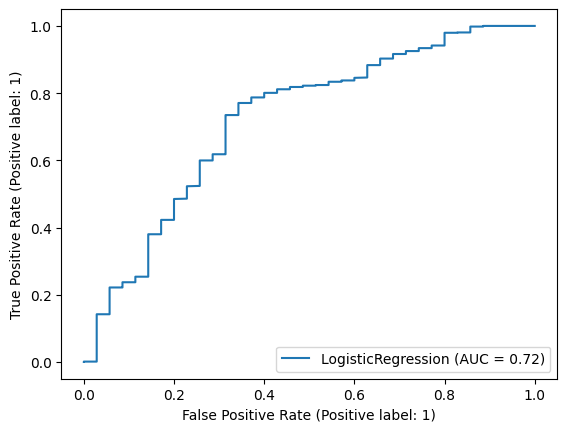

In [605]:
# ROC Curve for LR
plot_roc_curve(lr, X_train, y_train)

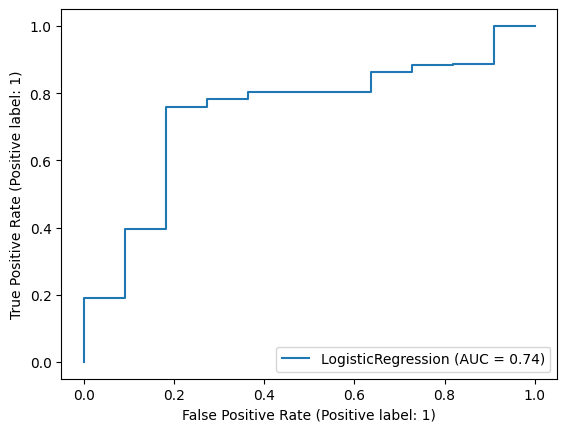

In [606]:
# ROC Curve for LR
plot_roc_curve(lr, X_test, y_test)

In [607]:
lasso_model = Lasso()
lasso_model.fit(X_train, y_train)

print("TRAIN: ", mean_absolute_error(y_train, lasso_model.predict(X_train)))
print("TEST : ", mean_absolute_error(y_test, lasso_model.predict(X_test)))

TRAIN:  0.06362534626038785
TEST :  0.07138281095998428


In [608]:
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

print("TRAIN: ", mean_absolute_error(y_train, ridge_model.predict(X_train)))
print("TEST : ", mean_absolute_error(y_test, ridge_model.predict(X_test)))

TRAIN:  0.06505947513725285
TEST :  0.07193967580644521


In [609]:
# LASSO
predictors = ['Male','Female','Age', 'CompensationAmount',
    'PhD', 'bachelors', 'high_school', 'masters', 'professional',
    'some_college', 'campus_recruitment', 'job_board', 'recruiter',
    'referral']
continuous_variables = ['Age', 'CompensationAmount']

X = df[predictors]
y = df['isEmployed']

#80/10 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# zscore (only continous and interval variables)
z = StandardScaler()
X_train[continuous_variables] = z.fit_transform(X_train[continuous_variables])
X_test[continuous_variables] = z.transform(X_test[continuous_variables]) 

lsr_tune = LassoCV(cv = 5).fit(X_train,y_train)
# lsr_tune = LassoCV(cv = 5, alphas = [0.001,0.01,0.05,1]).fit(X_train,y_train)

print("TRAIN: ", mean_absolute_error(y_train, lsr_tune.predict(X_train)))
print("TEST : ", mean_absolute_error(y_test, lsr_tune.predict(X_test)))

print("\nwe chose " + str(lsr_tune.alpha_) + " as our alpha.")

TRAIN:  0.07933222400909773
TEST :  0.05099455263650844

we chose 0.0007674094485277364 as our alpha.


In [610]:
# Ridge tuning
predictors = ['Male','Female','Age', 'CompensationAmount',
    'PhD', 'bachelors', 'high_school', 'masters', 'professional',
    'some_college', 'campus_recruitment', 'job_board', 'recruiter',
    'referral']
continuous_variables = ['Age', 'CompensationAmount']

X = df[predictors]
y = df['isEmployed']

#80/10 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# zscore (only continous and interval variables)
z = StandardScaler()
X_train[continuous_variables] = z.fit_transform(X_train[continuous_variables])
X_test[continuous_variables] = z.transform(X_test[continuous_variables]) 

rr_tune = RidgeCV(cv = 5).fit(X_train,y_train)

print("TRAIN: ", mean_absolute_error(y_train, rr_tune.predict(X_train)))
print("TEST : ", mean_absolute_error(y_test, rr_tune.predict(X_test)))

print("\nwe chose " + str(rr_tune.alpha_) + " as our alpha.")

TRAIN:  0.06547293978109352
TEST :  61.28604916349208

we chose 10.0 as our alpha.


In [611]:
#from scipy.stats import zscore
#z_scores = zscore(df['CompensationAmount'])
#df_clean = df[(z_scores < 3).all(axis=1) & (z_scores > -3).all(axis=1)]

# Remove Outliers
df = df[df['CompensationAmount'] < 250_000]
df = df[df['CompensationAmount'] > 10_000]

df = df[df['Age'] > 18]


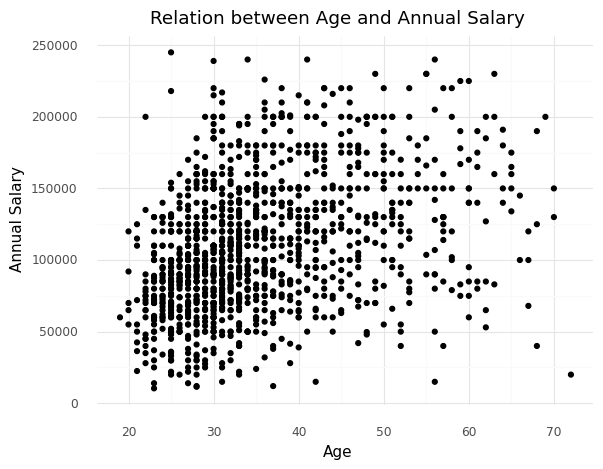

<ggplot: (733889374)>

In [612]:
(ggplot(df, aes(x = "Age", y = "CompensationAmount")) 
    + geom_point() 
    + theme_minimal()
    + ggtitle("Relation between Age and Annual Salary")
    + labs(x = "Age", y = "Annual Salary")
)

In [613]:
from sklearn.preprocessing import StandardScaler

features = ['Age', 'CompensationAmount']
z = StandardScaler()

df[features] = z.fit_transform(df[features])
gmm = GaussianMixture(n_components = 3).fit(df[features])
gmm_labels = gmm.predict(df[features])

#labList = ["Cluster " + str(i) for i in range(1, len(set(gmm.labels_)))]

df['assignments'] = gmm_labels

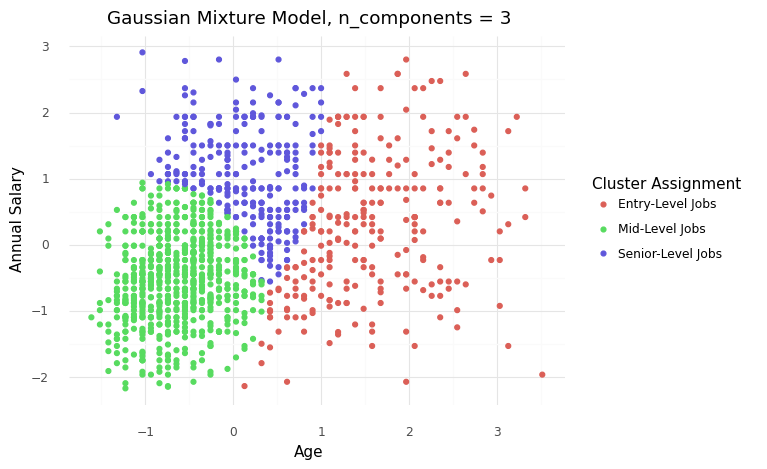

<ggplot: (732056096)>

In [614]:
(ggplot(df, aes(x = "Age", y = "CompensationAmount", color = "factor(assignments)"))
    + geom_point() 
    + theme_minimal()
    + labs(title = "Gaussian Mixture Model, n_components = 3", x = "Age", y = "Annual Salary")
    + scale_color_discrete(name = "Cluster Assignment", labels = (["Entry-Level Jobs", "Mid-Level Jobs", "Senior-Level Jobs"]))
)

In [615]:
ss_gmm = silhouette_score(df[features], df[['assignments']])
print("Silhouette Score for GM Model:", ss_gmm)

Silhouette Score for GM Model: 0.37444585744119585


In [616]:
#(ggplot(df, aes(x = "", y = 'value', fill = 'isEmployed')) + geom_bar(width = 1, stat = "identity") + coord_polar("y", start = 0))
#plot = df.plot.pie(subplots=True, figsize=(11,6))
#

df.groupby(['EmploymentStatus']).sum().plot(
    kind='pie', y='isEmployed', autopct='%1.0f%%')


KeyError: 'isEmployed'